## Normal
Объединить в один датафрейм данные по всем маркам машин. Преобразовать категориальные признаки.

Построить еще несколько моделей, используя подбор гиперпараметров. Сравнить между собой все построенные модели.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mlxtend.plotting import category_scatter, plot_decision_regions
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_score
import scipy.stats

from sklearn.model_selection import GridSearchCV

In [2]:
import glob
import os

all_files = glob.glob(os.path.join(r'D:\Курсы Питон\Машины\*.csv'))
data = []
for csv in all_files:
    frame = pd.read_csv(csv)
    frame['mark'] = os.path.basename(csv)[0:-4]
    data.append(frame)
df = pd.concat(data, ignore_index=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99187 entries, 0 to 99186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99187 non-null  object 
 1   year          99187 non-null  int64  
 2   price         99187 non-null  int64  
 3   transmission  99187 non-null  object 
 4   mileage       99187 non-null  int64  
 5   fuelType      99187 non-null  object 
 6   tax           99187 non-null  int64  
 7   mpg           99187 non-null  float64
 8   engineSize    99187 non-null  float64
 9   mark          99187 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 7.6+ MB


In [4]:
df.head(2)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,mark
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,audi


In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
standard_c = scaler.fit_transform(df[['year', 'mileage', 'tax', 'mpg', 'engineSize']])
standard_c = pd.DataFrame(standard_c, columns =['year', 'mileage', 'tax', 'mpg', 'engineSize'])
standard_c.head(2)

,year,mileage,tax,mpg,engineSize
0,-0.041302,-0.346310,0.470307,0.014448,-0.472130
1,-0.512129,0.621516,-1.588264,0.559730,0.603826


In [6]:
car_cat = df[['mark', 'transmission', 'fuelType', 'price']]
car_cat.head(2)

,mark,transmission,fuelType,price
0,audi,Manual,Petrol,12500
1,audi,Automatic,Diesel,16500


In [7]:
all_cars = pd.concat([standard_c, car_cat], axis=1)
all_cars.head(2)

,year,mileage,tax,mpg,engineSize,mark,transmission,fuelType,price
0,-0.041302,-0.346310,0.470307,0.014448,-0.472130,audi,Manual,Petrol,12500
1,-0.512129,0.621516,-1.588264,0.559730,0.603826,audi,Automatic,Diesel,16500


In [8]:
import category_encoders as ce
encoder = ce.one_hot.OneHotEncoder(cols=['mark', 'transmission', 'fuelType'])
all_cars = encoder.fit_transform(all_cars)
all_cars.head(2)

,year,mileage,tax,mpg,engineSize,mark_1,mark_2,mark_3,mark_4,mark_5,...,transmission_1,transmission_2,transmission_3,transmission_4,fuelType_1,fuelType_2,fuelType_3,fuelType_4,fuelType_5,price
0,-0.041302,-0.346310,0.470307,0.014448,-0.472130,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,12500
1,-0.512129,0.621516,-1.588264,0.559730,0.603826,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,16500


In [9]:
Xa = all_cars.drop(['price'], axis=1)
Ya = all_cars['price']

In [10]:
xa_train, xa_test, ya_train, ya_test = train_test_split(Xa, Ya, train_size=0.8)

In [11]:
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(xa_train, ya_train)

ya_lr_pred = lr.predict(xa_test)
r2_score(ya_test, ya_lr_pred)

0.7592562789823873

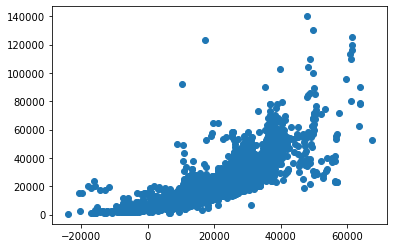

In [12]:
plt.scatter(ya_lr_pred, ya_test)

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn import linear_model

poly_lr = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    linear_model.Ridge(),
)
poly_lr.fit(xa_train, ya_train)
ya_poly_lr_pred = poly_lr.predict(xa_test)
r2_score(ya_test, ya_poly_lr_pred)

0.8928221682127859

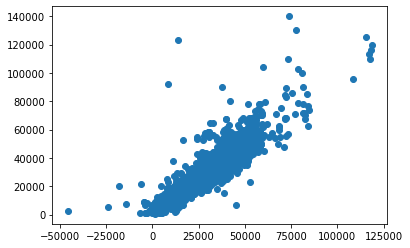

In [15]:
plt.scatter(ya_poly_lr_pred, ya_test)

In [16]:
poly_lrl = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    linear_model.Lasso()
)
poly_lrl.fit(xa_train, ya_train)
ya_poly_lrl_pred = poly_lrl.predict(xa_test)
r2_score(ya_test, ya_poly_lrl_pred)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.821e+11, tolerance: 7.696e+08
  model = cd_fast.enet_coordinate_descent(


0.8926169773366686

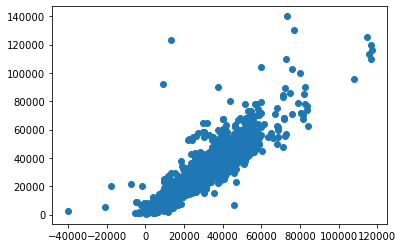

In [17]:
plt.scatter(ya_poly_lrl_pred, ya_test)

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=400)
rf.fit(xa_train, ya_train)
ya_rf_pred = rf.predict(xa_test)
r2_score(ya_test, ya_rf_pred)

0.935346866949768

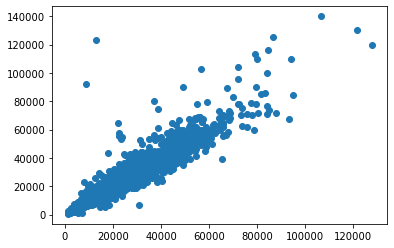

In [20]:
plt.scatter(ya_rf_pred, ya_test)

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [22]:
RGB = GradientBoostingRegressor()
RGB.fit(xa_train, ya_train)

ya_RGB_pred = RGB.predict(xa_test)
r2_score(ya_test, ya_RGB_pred)

0.8836022256597764

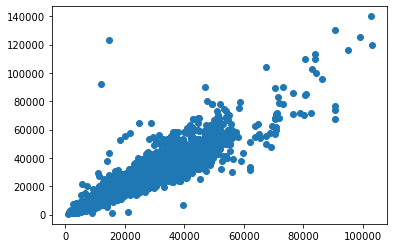

In [23]:
plt.scatter(ya_RGB_pred, ya_test)

In [24]:
AdaB = AdaBoostRegressor()
AdaB.fit(xa_train, ya_train)

ya_AdaB_pred = AdaB.predict(xa_test)
r2_score(ya_test, ya_AdaB_pred)

0.5168730927078475

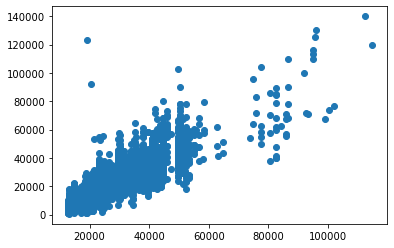

In [25]:
plt.scatter(ya_AdaB_pred, ya_test)

Стекинг

In [27]:
from sklearn.ensemble import StackingRegressor

estimators2 = [
    ('LinReg', LinearRegression()),
    ('RFR', RandomForestRegressor(max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=400)),
    ('GBR', GradientBoostingRegressor())
]
clf2=StackingRegressor(estimators=estimators2, final_estimator=make_pipeline(PolynomialFeatures(degree=3, include_bias=False), linear_model.Lasso()))

In [28]:
clf2.fit(xa_train, ya_train)
ya_clf2_pred = clf2.predict(xa_test)
r2_score(ya_test, ya_clf2_pred)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e+11, tolerance: 7.696e+08
  model = cd_fast.enet_coordinate_descent(


0.9365161699516484

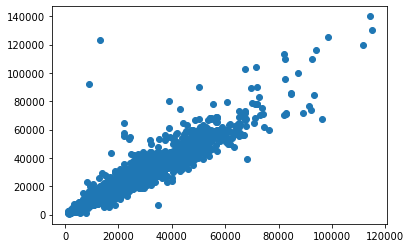

In [29]:
plt.scatter(ya_clf2_pred, ya_test)

### Подбор гиперпараметров

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
params = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300, 400, 500]}

In [ ]:
search = GridSearchCV(RandomForestRegressor(), params)
search.fit(xa_train, ya_train)
print('Best Params: ', search.best_estimator_)

## Сравнение построенных моделей

In [30]:
from sklearn.model_selection import cross_validate, cross_val_score
import scipy.stats

In [31]:
sample_lr = cross_validate(lr, xa_train, ya_train, scoring=['r2'], cv=15)
sample_poly_lr = cross_validate(poly_lr, xa_train, ya_train, scoring=['r2'], cv=15)
sample_poly_lrl = cross_validate(poly_lrl, xa_train, ya_train, scoring=['r2'], cv=15)
sample_rf = cross_validate(rf, xa_train, ya_train, scoring=['r2'], cv=15)
sample_RGB = cross_validate(RGB, xa_train, ya_train, scoring=['r2'], cv=15)
sample_AdaB = cross_validate(AdaB, xa_train, ya_train, scoring=['r2'], cv=15)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.552e+11, tolerance: 7.187e+08
  model = cd_fast.enet_coordinate_descent(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+11, tolerance: 7.136e+08
  model = cd_fast.enet_coordinate_descent(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.544e+11, tolerance: 7.169e+08
  model = cd_fast.enet_

In [32]:
from scipy import stats
F, p = stats.f_oneway(sample_lr['test_r2'], sample_poly_lr['test_r2'], sample_poly_lrl['test_r2'], sample_rf['test_r2'], sample_RGB['test_r2'], sample_AdaB['test_r2']) # однофакторный дисперсионный анализ
F_test = stats.f.ppf((1-0.05), 4, 15)
F, p

(232.176850557623, 1.2889130478197282e-47)

In [33]:
sample_lr['test_r2'].mean(), sample_poly_lr['test_r2'].mean(), sample_poly_lrl['test_r2'].mean(), sample_rf['test_r2'].mean(), sample_RGB['test_r2'].mean(), sample_AdaB['test_r2'].mean()

(0.7673809273251088,
 0.8751808393203857,
 0.8856880962993906,
 0.9456348092857078,
 0.8930154752020975,
 0.3831716990986674)

Случайный лес дает наиулучший результат